# Using Python to scrape data from Hardwarezone for sentiment analysis

In [ ]:
#General idea of 
#Select thread of interest from Hardwarezone (HWZ)
#Use beautifulsoup to extract data from HWZ
#Clean and process the data, prepare it for text analysis
#Cleaning the data: Fill NA values; change to lowercase; remove punctuation; remove stopwords; remove usernames; remove frequently occuring words; remove rare words; correct spelling
#Use nltk and textblob to conduct sentiment analysis: Looking at polarity and subjectivity of sentences
#USe matplotlib to generate 2 wordclouds - positive sentiment and negative sentiment

In [39]:
#import packages
from bs4 import BeautifulSoup
import urllib
import urllib.request
import re
import pandas as pd
import numpy as np
import os
from datetime import datetime
import requests
import csv
import textblob

headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36"}

URL_TMPL = "https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-{}.html"

for i in range(1):
    thread_url = URL_TMPL.format(i)
    print(thread_url)

resp = requests.get (thread_url, headers=headers)
content = resp.text
soup = BeautifulSoup(content, "lxml")
letters = soup.find_all("div", attrs={"id": re.compile ("^post_message_\d+")})
print (letters)


https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-0.html
[<div class="post_message" id="post_message_110647757">If you have never collect the free step tracker watch from Season 1-2, now is the time!<br/>
<font color="Red"><b><font size="2">Free watch(steps monitor) + can win supermarket vouchers easily </font></b></font><img alt="" border="0" class="inlineimg" src="https://www.hardwarezone.com.sg/img/forums/hwz/smilies/biggrin.gif" title="Big Grin"/><br/>
last year rewards is NTUC vouchers, this year i still not sure.<br/>
<br/>
<b>WHO CAN PARTICIPATE</b><br/>
Participants must be at least 17 years of age at the point of registration<br/>
<br/>
<b>CHALLENGE PERIOD</b><br/>
28 October 2017 to 30 April 2018<br/>
<br/>
Sign ups for Season 3 will start 29 September 2017 onwards.<br/>
<br/>
<b>WHO CAN COLLECT FREE HPB STEPS TRACKER</b><br/>
Only Singaporeans/Permanent Residents who 

In [3]:
#Choose the main site URL
site_url = 'https://forums.hardwarezone.com.sg'


In [4]:
#Retrieve the posts
#This function gets the thread URL, userid, timestamp, comments in the post text, post number and post id
# Credits to freedaemons/hwz-scrape for python code to retrieve content from HWZ

def getPosts(thread_url):
    #print(thread_url)
    lastThreadPage = False
    thread_cols = ['thread_url', 'userid', 'timestamp', 'post_text', 'post_number', 'post_id'] 
    thread_df = pd.DataFrame(columns=thread_cols)
    thread_page_url = thread_url

    while(not lastThreadPage):
        #print(thread_page_url)
        r3 = requests.get(thread_page_url)
        thread_page = r3.text
        thread_page_soup = BeautifulSoup(thread_page, 'html.parser')

        if (thread_page_soup.find('a', text='Next ›') == None):
            lastThreadPage = True
        else:
            thread_page_url = site_url + thread_page_soup.find('a', text='Next ›')['href']

        thread_page_posts = thread_page_soup.find('div', {'id': 'posts'})
        
        try: 
            for post in thread_page_posts.find_all('div', {'class': 'post-wrapper'}):
                userid_url = post.find('a', {'class': 'bigusername'})['href']
                userid = ''.join(filter(lambda x: x.isdigit(), userid_url))

                datetime_raw = post.find('a', {'name': lambda x: x and x.find('post') == 0}).nextSibling.strip()
                date_list = datetime_raw.split(',')[0].split('-')
                iso_date = '-'.join(list(reversed(date_list)))
                hour = int(datetime_raw.split(' ')[1][0:2])
                if(datetime_raw.split(' ')[2] == 'PM' and hour < 12):
                    hour += 12
                hour_str = str(hour)
                if(hour < 10):
                    hour_str = '0' + str(hour)
                minute = datetime_raw.split(':')[1][0:2]
                iso_datetime = iso_date + 'T' + hour_str + ':' + minute

                post_text = ""
                try:
                    post_text = post.find('div', {'class': 'post_message'}).get_text(' ', strip=True)
                except AttributeError as e: 
                    pass

                post_number = int(post.find('a', {'id': lambda x: x and 'postcount' in x, 'target': 'new'}).find('strong').get_text())

                post_id = int(post.find('a', {'id': lambda x: x and 'postcount' in x, 'target': 'new'})['id'].lstrip('postcount'))
                              
                row = pd.DataFrame([[thread_url, userid, iso_datetime, post_text, post_number, post_id]], columns=thread_cols)
                if(len(thread_df)==0):
                    thread_df = row
                else:
                    thread_df = thread_df.append(row, ignore_index=True) 
        except:
            row = pd.DataFrame([[thread_url, "", "", "", np.nan, np.nan]], columns=thread_cols) #posts missing, thread may have been deleted
            if(len(thread_df)==0):
                thread_df = row
            else:
                thread_df = thread_df.append(row, ignore_index=True) 
    thread_df['post_text'] = thread_df['post_text'].map(lambda x: x.encode('unicode-escape').decode('utf-8'))

    return thread_df

In [13]:
#Scrape the data - this will take a while depending on the number of pages in the thread. It took about 8 mins to get 500 pages of content
getPosts(thread_url)

#Save the data into a csv for cleaning
getPosts(thread_url).to_csv("nscdata.csv", encoding='utf-8')


https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-0.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-2.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-3.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-4.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-5.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-6.html
http

https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-51.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-52.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-53.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-54.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-55.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-56.htm

https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-101.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-102.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-103.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-104.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-105.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-1

https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-150.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-151.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-152.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-153.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-154.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-1

https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-199.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-200.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-201.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-202.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-203.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-2

https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-248.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-249.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-250.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-251.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-252.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-2

https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-297.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-298.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-299.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-300.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-301.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-3

https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-346.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-347.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-348.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-349.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-350.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-3

https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-395.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-396.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-397.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-398.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-399.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-4

https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-444.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-445.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-446.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-447.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-448.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-4

https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-493.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-494.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-495.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-496.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-497.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-4

https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-542.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-543.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-544.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-545.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-546.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-5

https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-591.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-592.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-593.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-594.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-595.html
https://forums.hardwarezone.com.sg/eat-drink-man-woman-16/national-steps-challenge%99-season-4-here-collect-free-heart-rate-monitoring-fitness-tracker-5702201-5

# Start the data cleaning process

In [2]:
#import csv to conducte sentiment analysis

data = pd.read_csv("nscdata.csv")

In [3]:
#eyeball the data
data.head

<bound method NDFrame.head of       Unnamed: 0                                         thread_url  userid  \
0              0  https://forums.hardwarezone.com.sg/eat-drink-m...  690068   
1              1  https://forums.hardwarezone.com.sg/eat-drink-m...  690068   
2              2  https://forums.hardwarezone.com.sg/eat-drink-m...  690068   
3              3  https://forums.hardwarezone.com.sg/eat-drink-m...  690068   
4              4  https://forums.hardwarezone.com.sg/eat-drink-m...  690068   
5              5  https://forums.hardwarezone.com.sg/eat-drink-m...     291   
6              6  https://forums.hardwarezone.com.sg/eat-drink-m...  690068   
7              7  https://forums.hardwarezone.com.sg/eat-drink-m...  410018   
8              8  https://forums.hardwarezone.com.sg/eat-drink-m...  690068   
9              9  https://forums.hardwarezone.com.sg/eat-drink-m...  646393   
10            10  https://forums.hardwarezone.com.sg/eat-drink-m...  410018   
11            11  http

In [4]:
#Begin cleaning the data

import nltk
from nltk.corpus import stopwords

In [5]:
#fill the NA values to make it empty string
data['post_text'] = data['post_text'].fillna("")

In [6]:
#change all words to lowercase
data['post_text'] = data['post_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['post_text'].head()

0    if you have never collect the free step tracke...
1    you may collect your hpb steps tracker* at the...
2    congratulations for completing 960km in nation...
3    quick start step 1 download the healthy 365 mo...
4    steps ___healthpoints (daily) 5000 ______ 10 7...
Name: post_text, dtype: object

In [7]:
#remove the punctuation
data['post_text'] = data['post_text'].str.replace('[^\w\s]','')
data['post_text'].head()


0    if you have never collect the free step tracke...
1    you may collect your hpb steps tracker at the ...
2    congratulations for completing 960km in nation...
3    quick start step 1 download the healthy 365 mo...
4    steps ___healthpoints daily 5000 ______ 10 750...
Name: post_text, dtype: object

In [8]:
#remove stopwords

stop = stopwords.words('english')
data['post_text'] = data['post_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data['post_text'].head()

0    never collect free step tracker watch season 1...
1    may collect hpb steps tracker following roadsh...
2    congratulations completing 960km national step...
3    quick start step 1 download healthy 365 mobile...
4    steps ___healthpoints daily 5000 ______ 10 750...
Name: post_text, dtype: object

In [9]:
#remove usernames and 'wrote:'
def remove_un(un):
    return re.sub(r'(.*^[A-Za-z0-9]+)|[^0-9A-Za-z]+(_wrote:)', '', un)

data['post_text'] = data.post_text.apply(remove_un)
data['post_text'].head(30)


0      collect free step tracker watch season 12 tim...
1      collect hpb steps tracker following roadshows...
2      completing 960km national steps challengeu212...
3      start step 1 download healthy 365 mobile app ...
4      ___healthpoints daily 5000 ______ 10 7500 ___...
5                                                   nao
6                                                caring
7                             register online get watch
8      wrote need register online get watch need go ...
9                                 tracker semo brand de
10     wrote need go roadshows early time last year ...
11     wrote step tracker semo brand de season 2 wat...
12               mi band 2 liao leh bind step challenge
13     wrote using mi band 2 liao leh bind step chal...
14           like watch right wrist 10000 steps problem
15     wrote wear like watch right wrist 10000 steps...
16     cake twentyonedegrees wrote must really walk ...
17     wrote wear like watch right wrist 10000 s

In [11]:
#check frequently occuring words

freq = pd.Series(' '.join(data['post_text']).split()).value_counts()[:25]
freq

wrote        6310
tracker      2844
app          2210
scan         2149
one          1819
steps        1697
2            1680
code         1573
qr           1482
got          1430
get          1412
points       1389
season       1371
sync         1347
using        1344
u            1303
hpb          1284
need         1282
go           1202
also         1169
still        1155
codes        1153
use          1150
1            1080
challenge    1055
dtype: int64

In [12]:
#remove commonly occuring words

freq = list(freq.index)
data['post_text'] = data['post_text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
data['post_text'].head()


0    collect free step watch 12 time free watchstep...
1    collect following roadshows available firstcom...
2    completing 960km national challengeu2122 compl...
3    start step download healthy 365 mobile create ...
4    ___healthpoints daily 5000 ______ 10 7500 ____...
Name: post_text, dtype: object

In [14]:
#remove rare words

freq = pd.Series(' '.join(data['post_text']).split()).value_counts()[-2700:]
freq

triangle                                    2
periodic                                    2
shugadotappdotlinkxe6tt13uxn                2
similarly                                   2
1730h                                       2
socks                                       2
tempted                                     2
incurred                                    2
yucks                                       2
67                                          2
240                                         2
brick                                       2
plaxa                                       2
sizes                                       2
rolling                                     2
persist                                     2
kiang                                       2
vivocity                                    2
winwin                                      2
interchange                                 2
rot                                         2
strait                            

In [15]:
#Remove rare words
freq = list(freq.index)
data['post_text'] = data['post_text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
data['post_text'].head()

0    collect free step watch 12 time free watchstep...
1    collect following roadshows available firstcom...
2    completing 960km national challengeu2122 compl...
3    start step download healthy 365 mobile create ...
4    ___healthpoints daily 5000 ______ 10 7500 ____...
Name: post_text, dtype: object

In [17]:
#spelling correction for first 15 lines only. This takes a really long time...

from textblob import TextBlob
data['post_text'][:15].apply(lambda x: str(TextBlob(x).correct()))
data['post_text'].head()

0    collect free step watch 12 time free watchstep...
1    collect following roadshows available firstcom...
2    completing 960km national challengeu2122 compl...
3    start step download healthy 365 mobile create ...
4    ___healthpoints daily 5000 ______ 10 7500 ____...
Name: post_text, dtype: object

In [18]:
#lemmatisation - convert words into root words

from textblob import Word
data['post_text'] = data['post_text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data['post_text'].head()

0    collect free step watch 12 time free watchstep...
1    collect following roadshows available firstcom...
2    completing 960km national challengeu2122 compl...
3    start step download healthy 365 mobile create ...
4    ___healthpoints daily 5000 ______ 10 7500 ____...
Name: post_text, dtype: object

In [19]:
#Save the processed text for sentiment analysis
data.to_csv('nscdata_modified.csv')


In [20]:
#Optional function - can choose to skip this
#Use inverse document frequency to identify words that are more important. It gives more weight to words that are important to determining the sentiment of the sentence
#filter and select the highest IDF rating
import pandas as pd
import nltk.corpus
import numpy as np
data2 = pd.read_csv("nscdata_modified.csv")

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', stop_words= 'english',ngram_range=(1,3))
tfidf_matrix = tfidf.fit_transform(data2['post_text'].values.astype('U'))

indices = np.argsort(tfidf.idf_)[::-1]
features = tfidf.get_feature_names()
top_n = 50
top_features = [features[i] for i in indices [:top_n]]
print (top_features)

['row', '12 hp', 'pastamania', 'passion card', 'tapformore', 'completerx92s kit', 'x96', 'net flashpay', 'pulling', 'paya lebar', 'trade', 'activation schedule', 'healthy 365 mobile', 'paya', 'spoof', 'completerx92s', 'cycling', 'health declaration', 's2', 'banner', 'miband', 'national challengex99', '15k', 'green light', '365 mobile', 'qq', 'qq rice', 'passion', 'sure win reward', 'challengeu2122', 'vibrating', '8pm', 'generation', 'health kit', '26', 'challengex99', 'healthpoint summary', 'nvr', 'report', 'pull strap', 'elderly', '500', 'die', 'paper', 'west', 'midnight', 'carebears', 'hp earned', 'bedok', 'sensitive']


# Start the sentiment analysis process

In [23]:
#Conduct Sentiment analysis using textblob package
from textblob import TextBlob
def sentiment_calc(post_text):
    try:
        return TextBlob(post_text).sentiment
    except:
        return None
data2['sentiment'] = data2['post_text'].apply(sentiment_calc)

data2 [['post_text','sentiment']].head()


,post_text,sentiment
0,collect free step watch 12 time free watchstep...,"(0.25757575757575757, 0.5080808080808081)"
1,collect following roadshows available firstcom...,"(0.05714285714285715, 0.1619047619047619)"
2,completing 960km national challengeu2122 compl...,"(0.14891774891774892, 0.40670995670995674)"
3,start step download healthy 365 mobile create ...,"(0.41666666666666674, 0.4270833333333333)"
4,___healthpoints daily 5000 ______ 10 7500 ____...,"(0.0, 0.0)"


In [24]:
#save the analysed data into a csv
data2.to_csv('nscdata_analysed.csv')

In [25]:
#separate the sentiment column into polarity and subjectivity
analysedfile = 'nscdata_analysed.csv'
bloblist = list()

with open(analysedfile, 'r') as csvfile:
    rows = csv.reader (csvfile)

    for row in rows:
        post_text = row[6]
        blob = TextBlob(post_text)
        bloblist.append((post_text,blob.sentiment.polarity, blob.sentiment.subjectivity))

df = pd.DataFrame(bloblist, columns = ['post_text','polarity','subjectivity'])
print(df)



                                              post_text  polarity  \
0                                             post_text  0.000000   
1     collect free step watch 12 time free watchstep...  0.257576   
2     collect following roadshows available firstcom...  0.057143   
3     completing 960km national challengeu2122 compl...  0.148918   
4     start step download healthy 365 mobile create ...  0.416667   
5     ___healthpoints daily 5000 ______ 10 7500 ____...  0.000000   
6                                                   nao  0.000000   
7                                                caring  0.000000   
8                                 register online watch  0.000000   
9     register online watch roadshows early time las...  0.050000   
10                                        semo brand de  0.000000   
11    roadshows early time last year see people queu...  0.150000   
12    step semo brand de watch actxa httpgdimagegmkt...  0.000000   
13                           mi ba

In [26]:
#Check the 20 comments with most positive sentiment and that are not subjective
pos_sen = df.sort_values(['polarity', 'subjectivity'], ascending = [False, True])
print (pos_sen.head(20))


#Check the 20 comments with most negative sentiment and that are not subjective

neg_sen = df.sort_values(['polarity', 'subjectivity'], ascending = [True, True])
print(neg_sen.head(20))

                                              post_text  polarity  \
142                             tell three best feature       1.0   
1337  _daikazoku close 5mil tender shitty tracker si...       1.0   
1348  surprise used work company bid gov project alw...       1.0   
1782                            best way replacement ah       1.0   
6902                            best shared x3 somemore       1.0   
6920  donu2019t worry best redeem check liao odachek...       1.0   
7276  best remove strap place see heartrate bmp shoo...       1.0   
7937  going collect completer kit ponggol today best...       1.0   
8817  _jan2004 collect mine charge power bank best c...       1.0   
2984          thfc78 carebears wonderful shopping month       1.0   
3996           perfectly wifi bluetooth location access       1.0   
3989  guy updated folder win mall read mall note fin...       0.8   
8909                     mvpa pledge win lol please lol       0.8   
91    going wwp collect maybe arou

(-0.5, 399.5, 199.5, -0.5)

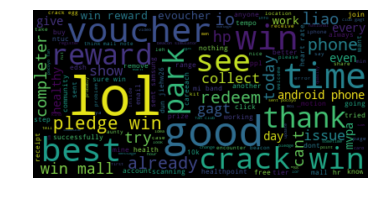

In [37]:
#Extract the 300 most positive sentiments to create a wordcloud 
pos_sen.head(300).post_text.to_csv("positivesen.csv",index=False)

import os
from os import path
from wordcloud import WordCloud


# Generate a word cloud image
wordcloud = WordCloud().generate(open("positivesen.csv").read())

# Display the generated image using matplotlib
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

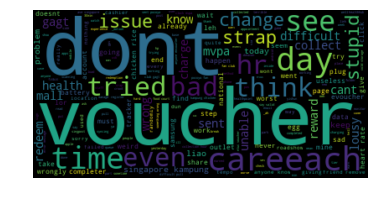

In [38]:
#Extract the 300 most negative sentiments to create a wordcloud 
neg_sen.head(300).post_text.to_csv("negativesen.csv",index=False)

import os
from os import path
from wordcloud import WordCloud


# Generate a word cloud image
wordcloud = WordCloud().generate(open("negativesen.csv").read())

# Display the generated image using matplotlib
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [ ]:
#End